# San Francisco Crime Classification

데이터 불러오기 및 초기설정

In [8]:
# 데이터 분석
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import urllib.request
import shutil
import zipfile
import os
import re

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 기계 학습
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [9]:
#데이터 로딩, parse_dates로 날짜. 파싱
train = pd.read_csv('data/train.csv', parse_dates=['Dates'])
test = pd.read_csv('data/test.csv', parse_dates=['Dates'], index_col='Id')

데이터 탐색

In [10]:
train.Dates.describe()

count                  878049
unique                 389257
top       2011-01-01 00:01:00
freq                      185
first     2003-01-06 00:01:00
last      2015-05-13 23:53:00
Name: Dates, dtype: object

In [11]:
train.shape
# 훈련 데이터는 2003.1.6.부터 2015.5.13.까지의 범죄를 담고 있으며, 총 9개의 features가 있습니다.

(878049, 9)

In [12]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [13]:
#9개의 feauture 각각의 데이터 타입
train.dtypes
#카테고리형 데이터(object)는 추후 인코딩 해야함

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

In [14]:
#중복행 체크 ->2323개의 행이 중복됨 -> 나중에 삭제 필요함
train.duplicated().sum()

2323

In [29]:
train.isnull().sum()
#결측값 확인

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Date          0
Year          0
Month         0
Day           0
Hour          0
dtype: int64

데이터 시각화

In [15]:
#Date 하나에 있는 것을 년, 월, 일,  시간으로 나눔
train['Date'] = train['Dates'].dt.date
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['Day'] = train['Dates'].dt.day
train['Hour'] = train['Dates'].dt.hour

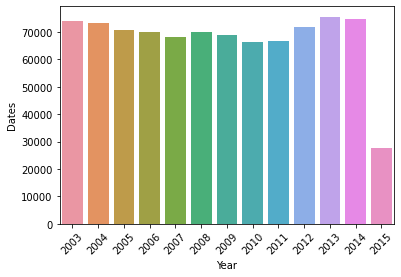

In [16]:
#연도에 따른 범죄수. 막대 그래프
year_series = train.groupby('Year').count().iloc[:, 0]
g = sns.barplot(x=year_series.index, y=year_series)
# 그래프 항목이름 설정, x축 레이블이 너무 길어서 45도 틀어줌
g.set_xticklabels(g.get_xticklabels(), rotation=45);

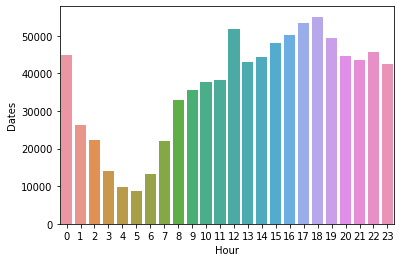

In [18]:
#시간에 따른 범죄 수
hour_series = train.groupby('Hour').count().iloc[:, 0]
sns.barplot(x=hour_series.index, y=hour_series);

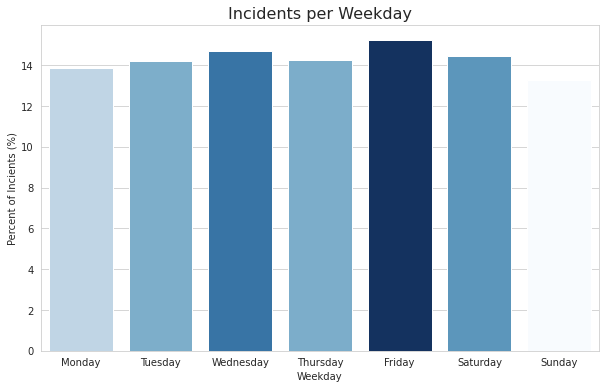

In [20]:
from matplotlib import cm
weekday_series = train.groupby('DayOfWeek').count().iloc[:,0]
weekday_series = weekday_series.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'])

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(1, figsize=(10, 6))
    sns.barplot(
        weekday_series.index, (weekday_series.values / weekday_series.values.sum()) * 100,
        palette=cm.ScalarMappable(cmap='Blues').to_rgba(weekday_series.values))

plt.title('Incidents per Weekday', fontdict={'fontsize':16})
plt.xlabel('Weekday')
plt.ylabel('Percent of Incients (%)');
#금요일에 가장 범죄 건수가 많음

In [32]:
weekday_series

DayOfWeek
Monday       121584
Tuesday      124965
Wednesday    129211
Thursday     125038
Friday       133734
Saturday     126810
Sunday       116707
Name: Dates, dtype: int64

데이터 전처리

In [21]:
#현재 데이터 속성 다시 확인
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Year,Month,Day,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,2015,5,13,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,2015,5,13,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13,2015,5,13,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13,2015,5,13,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13,2015,5,13,23


#category의 빈도수 확인
category_counts = train.groupby('Category').count().iloc[:, 0].sort_values(ascending=False)
category_counts
#절도(LARCENY/THEFT)의 비율이 가장 큼

In [ ]:
# OTHER OFFENSES를 제일 아래에 위치 시킴
category_counts = category_counts.reindex(
    np.append(np.delete(category_counts.index, 1), 'OTHER OFFENSES'))

In [25]:
#날짜별 주요 범죄 발생 확인
# as_index=False: Hour, Date, Category를 index로 지정하지 않음
data = train.groupby(['Hour', 'Date', 'Category'],
                    as_index=False).count().iloc[:, :4]
data

,Hour,Date,Category,Dates
0,0,2003-01-06,ASSAULT,3
1,0,2003-01-06,FORGERY/COUNTERFEITING,1
2,0,2003-01-06,LARCENY/THEFT,3
3,0,2003-01-06,OTHER OFFENSES,3
4,0,2003-01-06,ROBBERY,1
...,...,...,...,...
430787,23,2015-05-12,WEAPON LAWS,1
430788,23,2015-05-13,LARCENY/THEFT,5
430789,23,2015-05-13,OTHER OFFENSES,2
430790,23,2015-05-13,VEHICLE THEFT,2


Naive Prediction

In [26]:
naive_vals = train.groupby('Category').count().iloc[:, 0] / train.shape[0]
n_rows = test.shape[0]

naive_vals

Category
ARSON                          0.001723
ASSAULT                        0.087553
BAD CHECKS                     0.000462
BRIBERY                        0.000329
BURGLARY                       0.041860
DISORDERLY CONDUCT             0.004920
DRIVING UNDER THE INFLUENCE    0.002583
DRUG/NARCOTIC                  0.061467
DRUNKENNESS                    0.004874
EMBEZZLEMENT                   0.001328
EXTORTION                      0.000292
FAMILY OFFENSES                0.000559
FORGERY/COUNTERFEITING         0.012082
FRAUD                          0.018996
GAMBLING                       0.000166
KIDNAPPING                     0.002666
LARCENY/THEFT                  0.199192
LIQUOR LAWS                    0.002167
LOITERING                      0.001395
MISSING PERSON                 0.029599
NON-CRIMINAL                   0.105124
OTHER OFFENSES                 0.143707
PORNOGRAPHY/OBSCENE MAT        0.000025
PROSTITUTION                   0.008523
RECOVERED VEHICLE              

In [30]:
submission = pd.DataFrame(
    np.repeat(np.array(naive_vals), n_rows).reshape(39, n_rows).transpose(),
    columns=naive_vals.index)

In [31]:
submission
#train 데이터에서 각 Category의 비율을 test 데이터에 그대로 넣은 것입니다. 
#모든 row의 값은 동일합니다. submission했을 때 score는 2.68015입니다.

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
1,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
2,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
3,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
4,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
884258,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
884259,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
884260,0.001723,0.087553,0.000462,0.000329,0.04186,0.00492,0.002583,0.061467,0.004874,0.001328,...,0.000169,0.005171,0.000579,0.035777,0.000007,0.008343,0.050937,0.061251,0.048077,0.009743
